In [96]:
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('apple.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,2010-01-04,213.43,214.50,212.38,214.01,17633200.0,0.0,1.0,27.428730,27.566240,27.293790,27.503268,123432400.0
1,2010-01-05,214.60,215.59,213.25,214.38,21496600.0,0.0,1.0,27.579091,27.706320,27.405597,27.550818,150476200.0
2,2010-01-06,214.38,215.23,210.75,210.97,19720000.0,0.0,1.0,27.550818,27.660055,27.084312,27.112585,138040000.0
3,2010-01-07,211.75,212.00,209.05,210.58,17040400.0,0.0,1.0,27.212826,27.244955,26.865839,27.062465,119282800.0
4,2010-01-08,210.30,212.00,209.06,211.98,15986100.0,0.0,1.0,27.026481,27.244955,26.867124,27.242385,111902700.0


In [3]:
df.shape

(1762, 13)

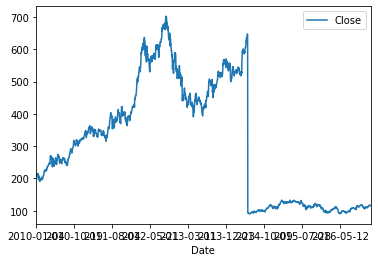

In [9]:
df.plot('Date', 'Close')

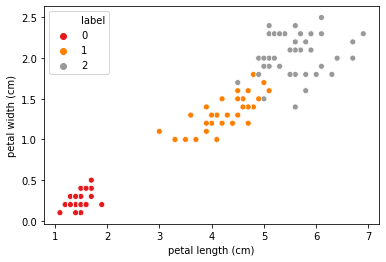

In [85]:
data = load_iris()
iris = pd.DataFrame(data.data, columns=data.feature_names)
iris['label'] = data.target

x_train, x_test, y_train, y_test = train_test_split(iris[['petal length (cm)', 'petal width (cm)']], iris[['label']])

sns.scatterplot(x='petal length (cm)', y='petal width (cm)',
                hue=y_train['label'], data=x_train, palette='Set1')

Accuracy:  0.9736842105263158


/home/jassi/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Predicted Labels')

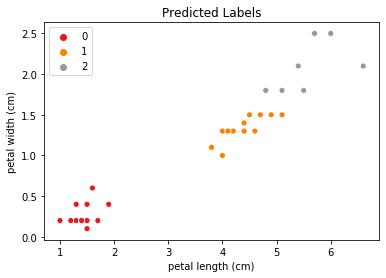

In [86]:
model = LinearSVC().fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy: ', accuracy_score(y_pred, y_test))

sns.scatterplot(x='petal length (cm)', y='petal width (cm)',
                hue=y_pred, data=x_test, palette='Set1')
plt.title('Predicted Labels')

Text(0.5, 1.0, 'True Labels')

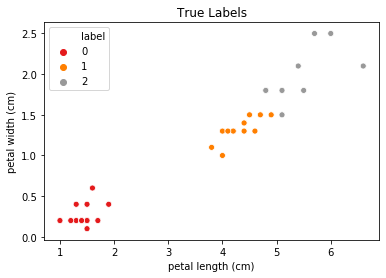

In [87]:
sns.scatterplot(x='petal length (cm)', y='petal width (cm)',
                hue=y_test['label'], data=x_test, palette='Set1')
plt.title('True Labels')

In [123]:
data = load_boston()
boston = pd.DataFrame(data.data, columns=data.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


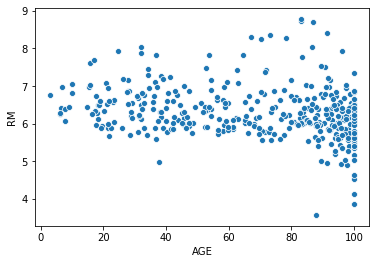

In [124]:
x = boston[['AGE']]
y = boston['RM']

x_train, x_test, y_train, y_test = train_test_split(x, y)

sns.scatterplot(x=x_train['AGE'], y=y_train)

In [125]:
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(mean_absolute_error(y_pred, y_test))

0.5394401939081982


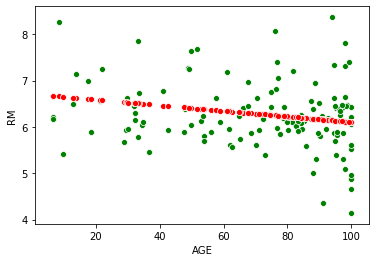

In [126]:
sns.scatterplot(x=x_test['AGE'], y=y_test, color='green')
sns.scatterplot(x=x_test['AGE'], y=y_pred, color='red')

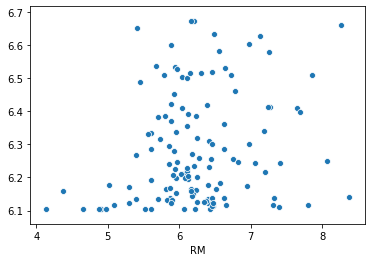

In [127]:
sns.scatterplot(x=y_test, y=y_pred)

In [141]:
# blah